In [1]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

In [2]:
data_dir = '/kaggle/input/klasifikasi-sampah/garbage_classification'
classes = os.listdir(data_dir)
print(classes)

['Anorganik', 'Berbahaya', 'Organik']


In [3]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

dataset = ImageFolder(data_dir, transform = transformations)

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

Label: Anorganik (Class No: 0)


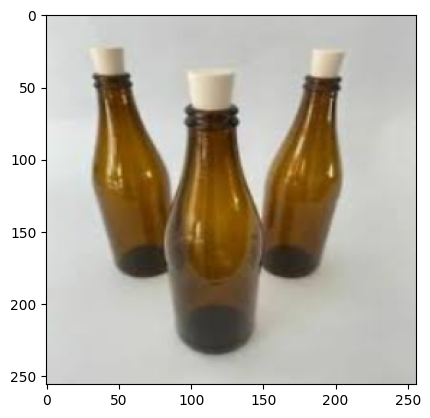

In [5]:
img, label = dataset[8]
show_sample(img, label)

In [6]:
random_seed = 42
torch.manual_seed(random_seed)

In [7]:
train_ds, val_ds, test_ds = random_split(dataset, [7757, 3103, 4655])
len(train_ds), len(val_ds), len(test_ds)

(7757, 3103, 4655)

In [8]:
from torch.utils.data.dataloader import DataLoader
batch_size = 32

In [9]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)

In [10]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

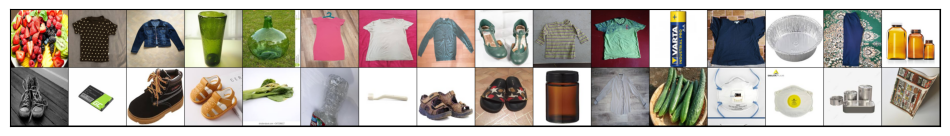

In [11]:
show_batch(train_dl)

In [12]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

In [13]:
import shutil

source_path = '/kaggle/input/package-resnet/resnet50-0676ba61.pth'
# Lokasi tujuan untuk memindahkan file ke cache PyTorch
destination_path = '/root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth'

# Buat direktori tujuan jika belum ada
os.makedirs(os.path.dirname(destination_path), exist_ok=True)

# Pindahkan file ke lokasi yang diinginkan
shutil.copy2(source_path, destination_path)

'/root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth'

In [14]:
from torchvision.models import resnet50, ResNet50_Weights

class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model with the updated weights parameter
        self.network = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = ResNet()

In [15]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [16]:
device = get_default_device()
device

device(type='cpu')

In [17]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [18]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [19]:
model = to_device(ResNet(), device)

In [20]:
evaluate(model, val_dl)

{'val_loss': 1.0992484092712402, 'val_acc': 0.22244280576705933}

In [21]:
num_epochs = 8
opt_func = torch.optim.Adam
lr = 5.5e-5

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch 1: train_loss: 0.6236, val_loss: 0.5705, val_acc: 0.9827
Epoch 2: train_loss: 0.5661, val_loss: 0.5657, val_acc: 0.9888
Epoch 3: train_loss: 0.5605, val_loss: 0.5655, val_acc: 0.9872
Epoch 4: train_loss: 0.5592, val_loss: 0.5650, val_acc: 0.9866
Epoch 5: train_loss: 0.5561, val_loss: 0.5624, val_acc: 0.9888
Epoch 6: train_loss: 0.5557, val_loss: 0.5653, val_acc: 0.9866
Epoch 7: train_loss: 0.5550, val_loss: 0.5639, val_acc: 0.9866
Epoch 8: train_loss: 0.5551, val_loss: 0.5652, val_acc: 0.9863


In [22]:
# Simpan model
torch.save(model.state_dict(), 'model_garbage_classification.pth')

In [23]:
# Inisialisasi ulang model
model = ResNet()

# Load model dari file
model.load_state_dict(torch.load('model_garbage_classification.pth'))

# Pindahkan model ke device
model = to_device(model, device)

# Model siap digunakan
evaluate(model, val_dl)

{'val_loss': 0.5652462244033813, 'val_acc': 0.9862882494926453}

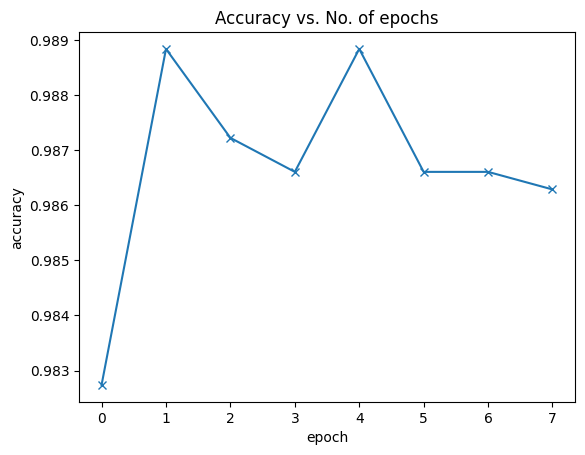

In [24]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

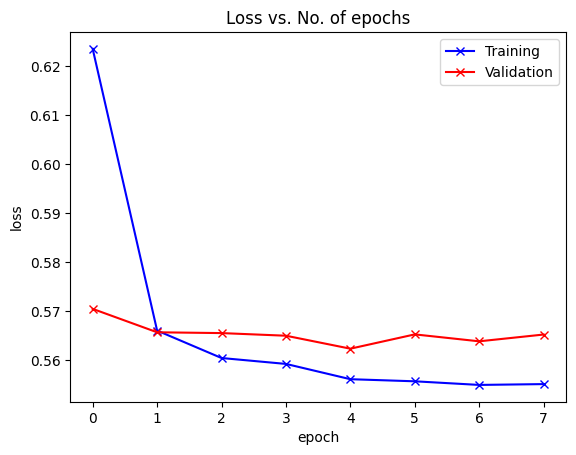

In [25]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

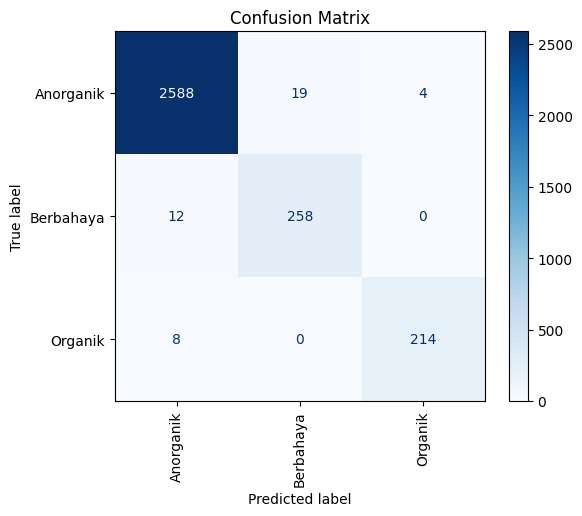

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Function to get all predictions and labels from the validation set
@torch.no_grad()
def get_all_preds_and_labels(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []
    for batch in val_loader:
        images, labels = batch
        preds = model(images)
        all_preds.append(preds)
        all_labels.append(labels)
    return torch.cat(all_preds), torch.cat(all_labels)

# Get predictions and labels
all_preds, all_labels = get_all_preds_and_labels(model, val_dl)

# Convert predictions to class indices
_, predicted_labels = torch.max(all_preds, dim=1)

# Compute confusion matrix
cm = confusion_matrix(all_labels.cpu(), predicted_labels.cpu())

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

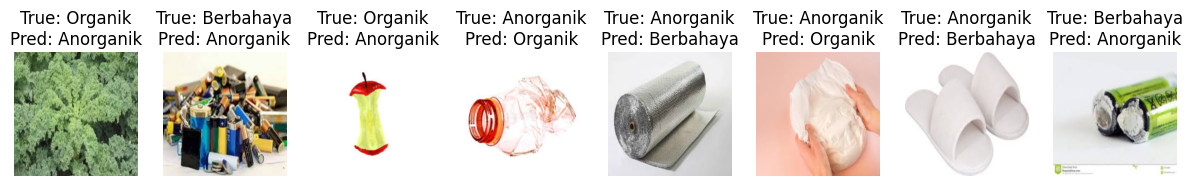

In [27]:
def show_misclassified_images(model, val_loader, dataset, num_images=5):
    model.eval()  # Set the model to evaluation mode
    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []

    with torch.no_grad():
        for batch in val_loader:
            images, labels = batch
            preds = model(images)
            _, predicted_labels = torch.max(preds, dim=1)

            # Identify misclassified samples
            for img, label, pred in zip(images, labels, predicted_labels):
                if label != pred:
                    misclassified_images.append(img)
                    misclassified_labels.append(label)
                    misclassified_preds.append(pred)

            # Stop if we have enough examples
            if len(misclassified_images) >= num_images:
                break

    # Display the misclassified images
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        img = misclassified_images[i]
        true_label = misclassified_labels[i].item()
        pred_label = misclassified_preds[i].item()

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img.permute(1, 2, 0).cpu())
        plt.title(f"True: {dataset.classes[true_label]}\nPred: {dataset.classes[pred_label]}")
        plt.axis('off')

    plt.show()

# Call the function to display misclassified images
show_misclassified_images(model, val_dl, dataset, num_images=8)


In [28]:
import os
import shutil

# Buat folder untuk menyimpan gambar test
test_image_dir = '/kaggle/working/test_images'
os.makedirs(test_image_dir, exist_ok=True)

# Salin gambar test ke folder tersebut
for i in test_ds.indices:
    src_path = dataset.imgs[i][0]  # Path asli gambar
    dst_path = os.path.join(test_image_dir, os.path.basename(src_path))  # Path tujuan
    shutil.copy(src_path, dst_path)

# Verifikasi bahwa gambar telah tersalin
print(f"Total {len(os.listdir(test_image_dir))} test images copied.")

# Membuat zip file dari folder test_images
shutil.make_archive('/kaggle/working/test_images', 'zip', test_image_dir)

# Setelah ini, Anda bisa mengunduh file ZIP dari panel Output Files di Kaggle

Total 4655 test images copied.


'/kaggle/working/test_images.zip'

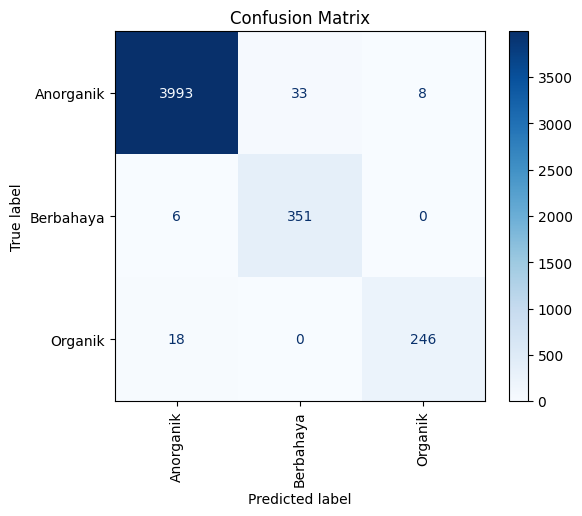

In [29]:
test_dl = DataLoader(test_ds, batch_size*2, num_workers = 4, pin_memory = True)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Function to get all predictions and labels from the testing set
@torch.no_grad()
def get_all_preds_and_labels(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    for batch in test_loader:
        images, labels = batch
        preds = model(images)
        all_preds.append(preds)
        all_labels.append(labels)
    return torch.cat(all_preds), torch.cat(all_labels)

# Get predictions and labels
all_preds, all_labels = get_all_preds_and_labels(model, test_dl)

# Convert predictions to class indices
_, predicted_labels = torch.max(all_preds, dim=1)

# Compute confusion matrix
cm = confusion_matrix(all_labels.cpu(), predicted_labels.cpu())

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

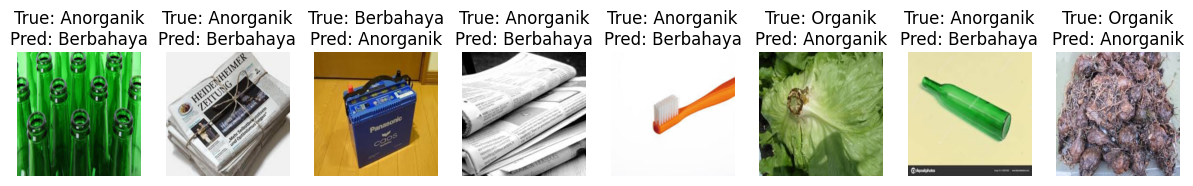

In [30]:
def show_misclassified_images(model, test_loader, dataset, num_images=5):
    model.eval()  # Set the model to evaluation mode
    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []

    with torch.no_grad():
        for batch in test_loader:
            images, labels = batch
            preds = model(images)
            _, predicted_labels = torch.max(preds, dim=1)

            # Identify misclassified samples
            for img, label, pred in zip(images, labels, predicted_labels):
                if label != pred:
                    misclassified_images.append(img)
                    misclassified_labels.append(label)
                    misclassified_preds.append(pred)

            # Stop if we have enough examples
            if len(misclassified_images) >= num_images:
                break

    # Display the misclassified images
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        img = misclassified_images[i]
        true_label = misclassified_labels[i].item()
        pred_label = misclassified_preds[i].item()

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img.permute(1, 2, 0).cpu())
        plt.title(f"True: {dataset.classes[true_label]}\nPred: {dataset.classes[pred_label]}")
        plt.axis('off')

    plt.show()

# Call the function to display misclassified images
show_misclassified_images(model, test_dl, dataset, num_images=8)

In [31]:
# Buat folder untuk menyimpan gambar test
train_image_dir = '/kaggle/working/train_images'
os.makedirs(train_image_dir, exist_ok=True)

# Salin gambar test ke folder tersebut
for i in train_ds.indices:
    src_path = dataset.imgs[i][0]  # Path asli gambar
    dst_path = os.path.join(train_image_dir, os.path.basename(src_path))  # Path tujuan
    shutil.copy(src_path, dst_path)

# Verifikasi bahwa gambar telah tersalin
print(f"Total {len(os.listdir(train_image_dir))} train images copied.")

# Membuat zip file dari folder test_images
shutil.make_archive('/kaggle/working/train_images', 'zip', train_image_dir)

# Setelah ini, Anda bisa mengunduh file ZIP dari panel Output Files di Kaggle

Total 7757 train images copied.


'/kaggle/working/train_images.zip'

In [32]:
# Buat folder untuk menyimpan gambar test
val_image_dir = '/kaggle/working/val_images'
os.makedirs(val_image_dir, exist_ok=True)

# Salin gambar test ke folder tersebut
for i in val_ds.indices:
    src_path = dataset.imgs[i][0]  # Path asli gambar
    dst_path = os.path.join(val_image_dir, os.path.basename(src_path))  # Path tujuan
    shutil.copy(src_path, dst_path)

# Verifikasi bahwa gambar telah tersalin
print(f"Total {len(os.listdir(val_image_dir))} val images copied.")

# Membuat zip file dari folder test_images
shutil.make_archive('/kaggle/working/val_images', 'zip', val_image_dir)

# Setelah ini, Anda bisa mengunduh file ZIP dari panel Output Files di Kaggle

Total 3103 val images copied.


'/kaggle/working/val_images.zip'

In [33]:
# Path folder baru
new_data_dir = '/kaggle/input/data-baru/datatest_baru'

# Gunakan ImageFolder untuk memuat dataset baru
new_dataset = ImageFolder(new_data_dir, transform=transformations)

# Buat DataLoader untuk dataset baru
new_dl = DataLoader(new_dataset, batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Pindahkan DataLoader ke device yang sesuai
new_dl = DeviceDataLoader(new_dl, device)

# Evaluasi model pada data baru
@torch.no_grad()
def evaluate_new_data(model, new_loader):
    model.eval()
    all_preds = []
    all_labels = []
    for batch in new_loader:
        images, labels = batch
        preds = model(images)
        all_preds.append(preds)
        all_labels.append(labels)
    return torch.cat(all_preds), torch.cat(all_labels)

# Dapatkan prediksi dan label dari data baru
all_preds, all_labels = evaluate_new_data(model, new_dl)

# Ubah prediksi menjadi indeks kelas
_, predicted_labels = torch.max(all_preds, dim=1)



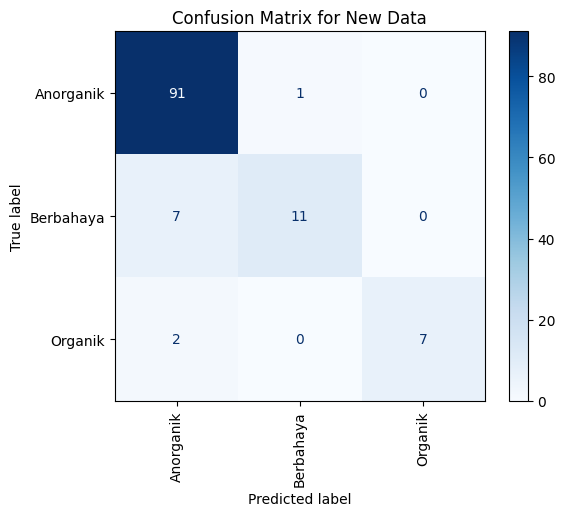

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Hitung confusion matrix
cm = confusion_matrix(all_labels.cpu(), predicted_labels.cpu())

# Tampilkan confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=new_dataset.classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix for New Data')
plt.show()


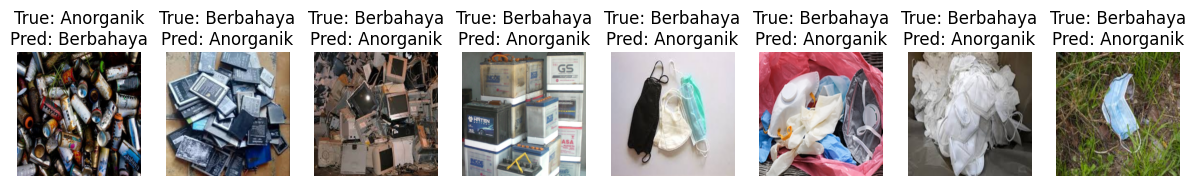

In [35]:

# Fungsi untuk menampilkan gambar yang salah diprediksi
def show_misclassified_images_new(model, new_loader, dataset, num_images=5):
    model.eval()  # Set model ke mode evaluasi
    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []

    with torch.no_grad():
        for batch in new_loader:
            images, labels = batch
            preds = model(images)
            _, predicted_labels = torch.max(preds, dim=1)

            # Identifikasi gambar yang salah diklasifikasikan
            for img, label, pred in zip(images, labels, predicted_labels):
                if label != pred:
                    misclassified_images.append(img)
                    misclassified_labels.append(label)
                    misclassified_preds.append(pred)

            # Berhenti jika jumlah gambar salah cukup
            if len(misclassified_images) >= num_images:
                break

    # Tampilkan gambar yang salah diprediksi
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        img = misclassified_images[i]
        true_label = misclassified_labels[i].item()
        pred_label = misclassified_preds[i].item()

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img.permute(1, 2, 0).cpu())
        plt.title(f"True: {dataset.classes[true_label]}\nPred: {dataset.classes[pred_label]}")
        plt.axis('off')

    plt.show()

# Panggil fungsi untuk menampilkan gambar yang salah diprediksi dari dataset baru
show_misclassified_images_new(model, new_dl, new_dataset, num_images=8)


In [36]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: Anorganik , Predicted: Anorganik


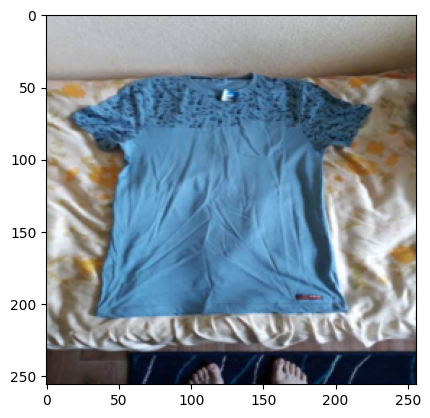

In [37]:
img, label = test_ds[17]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: Berbahaya , Predicted: Berbahaya


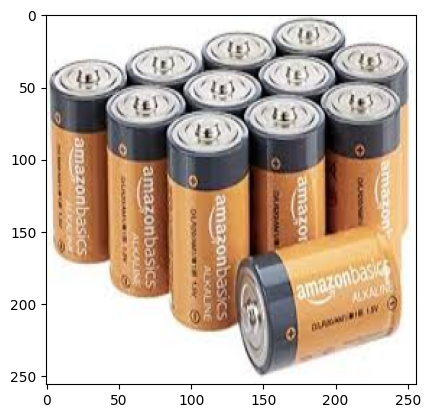

In [38]:
img, label = test_ds[3999]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: Organik , Predicted: Organik


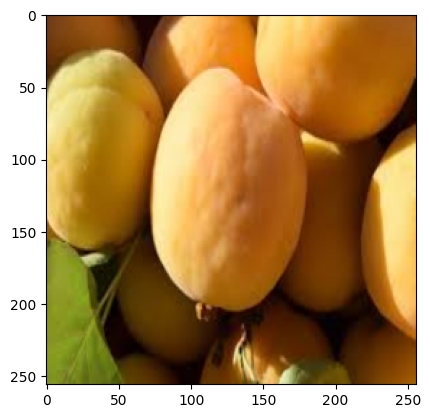

In [39]:
img, label = test_ds[25]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [40]:
from PIL import Image
import os

# Fungsi untuk memuat gambar baru, menerapkan transformasi, dan mengklasifikasikannya
def classify_new_image(image_path, label, model, transform, dataset):
    # Muat gambar dari path
    img = Image.open(image_path).convert('RGB')  # Pastikan gambar dalam format RGB
    
    # Terapkan transformasi yang sama seperti pada data pelatihan
    img_transformed = transformations(img)
    
    # Prediksi gambar
    predicted_class = predict_image(img_transformed, model)
    
    # Tampilkan gambar yang sudah ditransformasikan
    plt.imshow(img_transformed.permute(1, 2, 0))  # Tensor butuh permute agar dimensinya cocok untuk plt.imshow
    plt.title(f"True Label: {label} | Predicted: {predicted_class}")
    plt.axis('on')
    plt.show()


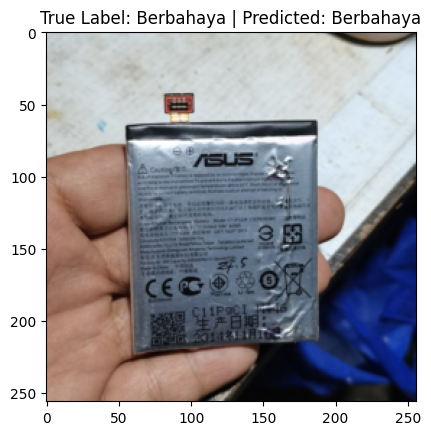

In [41]:
# Path ke gambar baru
new_image_path = '/kaggle/input/datatest/baterai.jpg'
true_label = 'Berbahaya'  # Masukkan label gambar yang sesuai

# Lakukan prediksi pada gambar baru
classify_new_image(new_image_path, true_label, model, transformations, dataset)

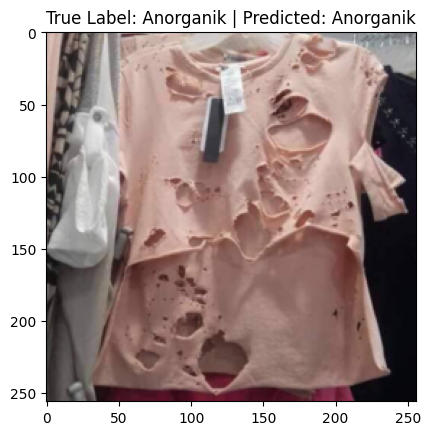

In [42]:
# Path ke gambar baru
new_image_path = '/kaggle/input/datatest/pakaian.jpeg'
true_label = 'Anorganik'  # Masukkan label gambar yang sesuai

# Lakukan prediksi pada gambar baru
classify_new_image(new_image_path, true_label, model, transformations, dataset)

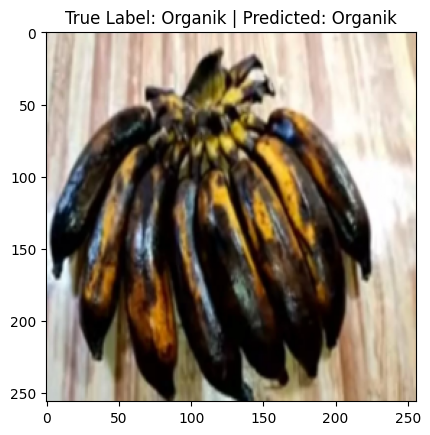

In [43]:
# Path ke gambar baru
new_image_path = '/kaggle/input/datatest/pisang.webp'
true_label = 'Organik'  # Masukkan label gambar yang sesuai

# Lakukan prediksi pada gambar baru
classify_new_image(new_image_path, true_label, model, transformations, dataset)